# Predict Customer Lifetime

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
import shap

from lifelines import ExponentialFitter, GeneralizedGammaRegressionFitter
from lifelines import WeibullFitter, LogNormalFitter, LogLogisticFitter
from lifelines import LogNormalAFTFitter, LogLogisticAFTFitter, WeibullAFTFitter, CoxPHFitter

from lifelines.utils import concordance_index
from lifelines.plotting import qq_plot
from lifelines.utils import find_best_parametric_model

from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.util import Surv

# import custom data class
from data.processing.processing import ChurnData

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# import churn dataset
data = ChurnData(filename='data/telco_customer_churn.csv', testsize=.33, seed=123)
data.load_data()
data.process_data()


In [3]:
data.churn_df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1.001,29,29,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0,34.001,56,1889,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,2.001,53,108,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,0,45.001,42,1840,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,2.001,70,151,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1


In [4]:
data.churn_df_uncensored.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2,0,2.001,53,108,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,2.001,70,151,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
5,0,8.001,99,820,0,0,0,1,0,1,...,0,1,0,1,0,0,1,0,1,0
8,0,28.001,104,3046,0,1,0,1,0,1,...,0,1,0,1,0,0,1,0,1,0
13,0,49.001,103,5036,1,0,0,1,0,1,...,0,1,0,1,0,0,1,0,0,0


In [5]:
data.churn_df.dtypes

SeniorCitizen                              int32
tenure                                   float64
MonthlyCharges                             int32
TotalCharges                               int32
gender_Male                                int32
Partner_Yes                                int32
Dependents_Yes                             int32
PhoneService_Yes                           int32
MultipleLines_No phone service             int32
MultipleLines_Yes                          int32
InternetService_Fiber optic                int32
InternetService_No                         int32
OnlineSecurity_No internet service         int32
OnlineSecurity_Yes                         int32
OnlineBackup_No internet service           int32
OnlineBackup_Yes                           int32
DeviceProtection_No internet service       int32
DeviceProtection_Yes                       int32
TechSupport_No internet service            int32
TechSupport_Yes                            int32
StreamingTV_No inter

In [6]:
data.churn_df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.372149,64.295897,2282.830754,0.504756,0.483033,0.299588,0.903166,0.096834,0.421837,...,0.384353,0.216669,0.387903,0.209144,0.240664,0.592219,0.216101,0.335794,0.228880,0.265370
std,0.368612,24.559481,30.092727,2264.997388,0.500013,0.499748,0.458110,0.295752,0.295752,0.493888,...,0.486477,0.412004,0.487307,0.406726,0.427517,0.491457,0.411613,0.472301,0.420141,0.441561
min,0.000000,0.001000,18.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.001000,35.000000,401.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.001000,70.000000,1400.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,55.001000,89.000000,3786.500000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,72.001000,118.000000,8684.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Exploratory Data Analysis

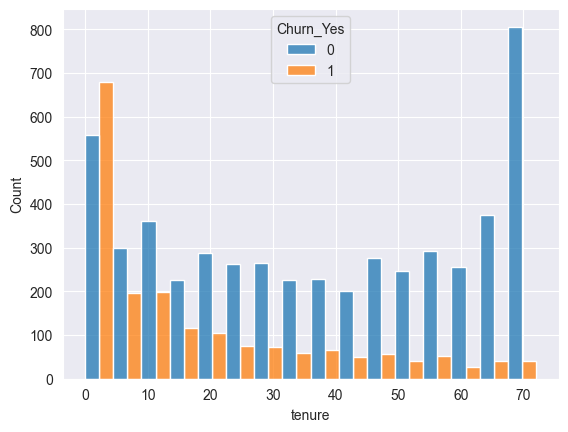

In [7]:
sns.histplot(
    data=data.churn_df,
    x='tenure',
    hue='Churn_Yes',
    multiple='dodge')
plt.show()

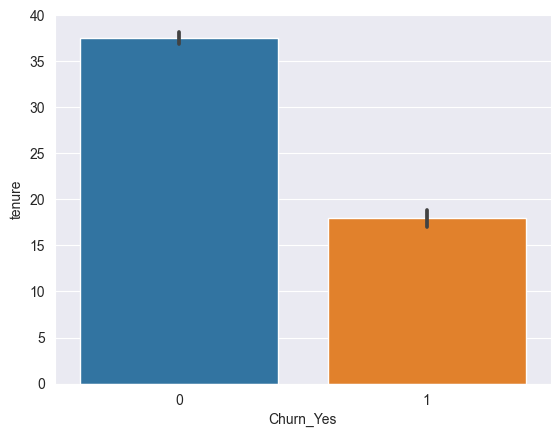

In [8]:
sns.barplot(
    data = data.churn_df,
    y = 'tenure',
    x = 'Churn_Yes'   
)
plt.show()

# Modeling 
## Regression Model for Lifetime Prediction (i.e. Tenure)

First let´s do "classical" machine learning to estimate the tenure values in the datasets of churners i.e. the uncensored data on which we can train a standard regression model

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from lifelines.utils import concordance_index

class LifetimeRegressionModel:
    def __init__(self, train_dataset: pd.DataFrame, test_dataset: pd.DataFrame, seed: int):
        self.seed = seed
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.target = 'tenure'
        self.features = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.model = None

    def get_feature_names(self):
        features = self.train_dataset.columns.to_list()
        features.remove('TotalCharges')
        features.remove('tenure')
        self.features = features

    def separate_features_and_target(self):
        self.X_train = self.train_dataset[self.features]
        self.y_train = self.train_dataset['tenure'].values
        self.X_test = self.test_dataset[self.features]
        self.y_test = self.test_dataset['tenure'].values

    def build_model(self):
        self.get_feature_names()
        self.separate_features_and_target()
        self.model = GradientBoostingRegressor(random_state=self.seed).fit(self.X_train, self.y_train)

    def evaluate_model(self):
        print('r2-score on training set: {:.2f}'.format(r2_score(self.y_train, self.model.predict(lrm.X_train))))
        print('r2-score on test set: {:.2f}'.format(r2_score(self.y_test, self.model.predict(lrm.X_test))))
        print('rmse on training set: {:.2f}'.format(np.sqrt(mean_squared_error(self.y_train, self.model.predict(lrm.X_train)))))
        print('rmse on test set: {:.2f}'.format(np.sqrt(mean_squared_error(self.y_test, self.model.predict(lrm.X_test)))))
        print('c-index on train set: {:.2f}'.format(concordance_index(event_times=self.y_train, predicted_scores=self.model.predict(self.X_train))))
        print('c-index on test set: {:.2f}'.format(concordance_index(event_times=self.y_test, predicted_scores=self.model.predict(self.X_test))))

    def plot_feature_importance(self):
        importances = self.model.feature_importances_
        forest_importances = pd.Series(importances, index=self.features)
        forest_importances = pd.DataFrame(data=forest_importances, columns=['importance']).sort_values(by='importance', ascending=True)
        fig, ax = plt.subplots()
        forest_importances.plot.barh(ax=ax)
        ax.set_title("Feature Importance using Log-Loss")
        ax.set_ylabel("Mean log-loss")
        fig.tight_layout()

    def plot_shap_feature_importance(self, plot_type: str):
        """plot_type can be 'bar' or 'violin'"""
        explainer = shap.TreeExplainer(
            model = self.model,
            data = self.X_test,
            feature_perturbation = "interventional",
            model_output='raw')
        shap_values = explainer.shap_values(self.X_test, check_additivity=True)
        shap.summary_plot(
            shap_values=shap_values,
            features=self.X_test,
            plot_type=plot_type
        )

    def plot_model_prediction(self):
        plt.scatter(x=self.y_test, y=self.model.predict(self.X_test))
        plt.plot([min(self.y_test), max(self.y_test)], [min(self.y_test), max(self.y_test)], color='red', linestyle='--')
        plt.title('Tenure: Predicted vs Actual')
        plt.xlabel('actual tenure [month]')
        plt.ylabel('predicted tenure [month]')
        plt.grid()
        plt.show()



In [10]:
# instantiate model
lrm = LifetimeRegressionModel(
    train_dataset=data.churn_df_uncensored_train,
    test_dataset=data.churn_df_uncensored_test,
    seed=123
)
# build model
lrm.build_model()
# evaluate model
lrm.evaluate_model()

r2-score on training set: 0.66
r2-score on test set: 0.53
rmse on training set: 11.44
rmse on test set: 13.51
c-index on train set: 0.79
c-index on test set: 0.76


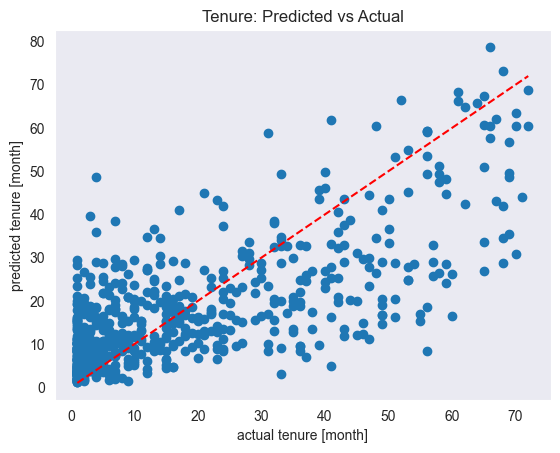

In [11]:
# visualize model
lrm.plot_model_prediction()

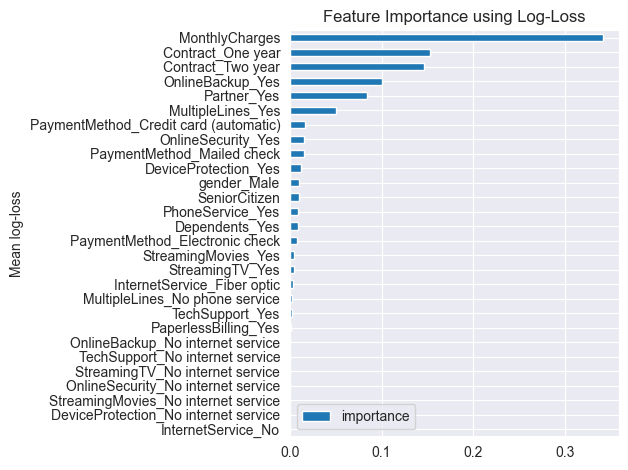

In [12]:
# plot feature importance
lrm.plot_feature_importance()

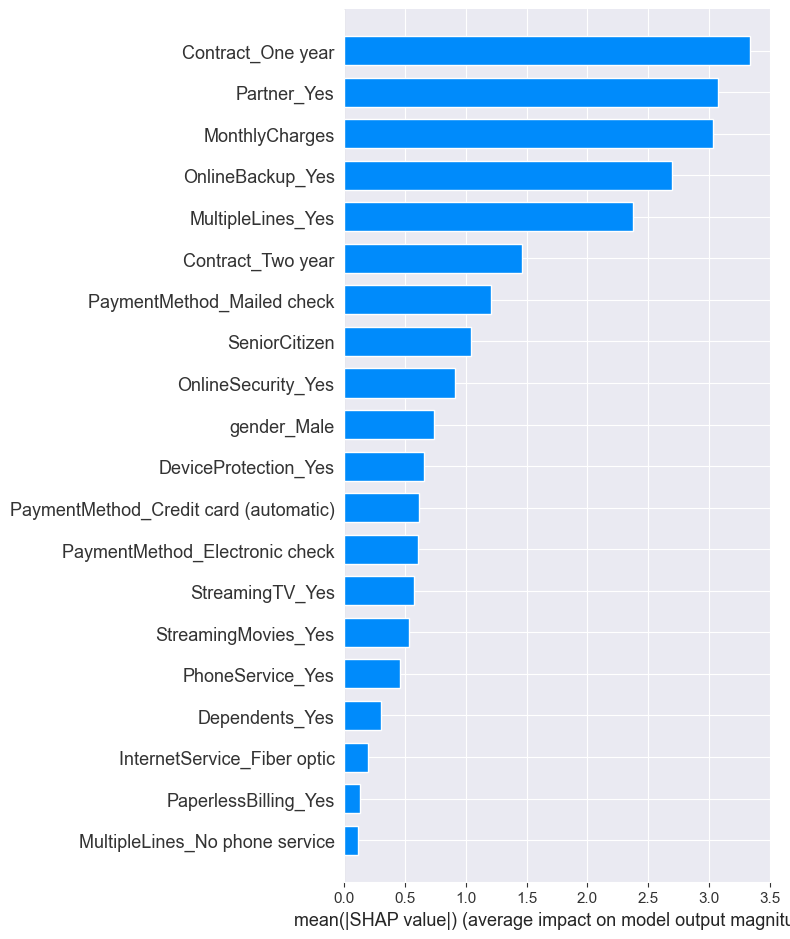

In [13]:
lrm.plot_shap_feature_importance(plot_type='bar')

## Conclusion
We cannot robustly predict tenure i.e. the number of month a customer will stay before churning beforehand; Let´s try to predict churn itself

## Classification Model for Churn-Prediction

In [14]:
features = tenure_df_train.columns.to_list()
features.remove('Churn_Yes')

features

NameError: name 'tenure_df_train' is not defined

In [ ]:
X_train =  tenure_df_train[features]
y_train =  tenure_df_train['Churn_Yes'].values

In [ ]:
X_test =  tenure_df_test[features]
y_test =  tenure_df_test['Churn_Yes'].values

In [ ]:
clf = GradientBoostingClassifier(random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
# accuracy score on training set
clf.score(X_train, y_train)

In [ ]:
# accuracy score on test set
clf.score(X_test, y_test)

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
# precision recall curve
y_score = clf.decision_function(X_test)
prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
plt.grid()

## Feature Importance

In [ ]:
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances using Log-Loss")
ax.set_ylabel("Mean log-loss")
fig.tight_layout()


In [ ]:

explainer = shap.TreeExplainer(
    model=clf,
    data = X_test,
    feature_perturbation = "interventional",
    model_output='probability')

In [ ]:
shap_values = explainer.shap_values(X_test, check_additivity=True)

In [ ]:
shap.summary_plot(
    shap_values=shap_values, 
    features=X_test, 
    plot_type='bar'
    )

In [ ]:
shap.summary_plot(
    shap_values=shap_values, 
    features=X_test, 
    plot_type='violin'
    )

In [ ]:
for f in data.numeric_features[:2]:
    fig, ax = plt.subplots(1,1)
    ax.grid()
    shap.dependence_plot(
        ind=f,
        shap_values=shap_values,
        features=X_test,
        interaction_index='auto',
        ax=ax
    )

# Survival Analysis
## Find best univariate model

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.reshape(4,)

T = tenure_df_train['tenure']
E = tenure_df_train['Churn_Yes']

for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(T, E)
    qq_plot(model, ax=axes[i])

## Training Weibull Model

In [ ]:
import numpy as np
from lifelines import WeibullAFTFitter, CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.metrics import r2_score

class ChurnModels:
    def __init__(self):
        self.wb_aft_model = WeibullAFTFitter()
        self.cph_model = CoxPHFitter(penalizer=0.01)

    def fit(self, data:pd.DataFrame, duration_col:str, event_col:str, model_type:str):
        if model_type == 'WeibullAFT':
            self.wb_aft_model.fit(data, duration_col, event_col)
        elif model_type == 'CoxPH':
            self.cph_model.fit(data, duration_col, event_col)
        else:
            pass
    
    def summary(self, model_type:str):
        if model_type == 'WeibullAFT':
            return self.wb_aft_model.summary
        elif model_type == 'CoxPH':
            return self.cph_model.summary
        else:
            pass

    def predict_expected_lifetime(self, data:pd.DataFrame, model_type:str):
        if model_type == 'WeibullAFT':
            return self.wb_aft_model.predict_expectation(data)
        elif model_type == 'CoxPH':
            return self.cph_model.predict_expectation(data.drop(['tenure', 'Churn_Yes'], axis=1))
        else:
            pass
    
    def eval_concordance_index(self, event_times:pd.Series, event_predictions:pd.Series):
        "the r2 score should be best evaluated on uncensored subset of the data"
        return np.round(concordance_index(event_times, event_predictions), 2)
    
    def eval_r2_score(self, event_times:pd.Series, event_predictions:pd.Series):
        "the r2 score should be best evaluated on uncensored subset of the data"
        return np.round(r2_score(event_times, event_predictions), 2)

    


In [ ]:
# initialize model
models = ChurnModels()

# fit Weibull-ATF model on all i.e. right-censored data
models.fit(
    data=tenure_df_train, 
    duration_col='tenure', 
    event_col='Churn_Yes',
    model_type='WeibullAFT')

# fit CoxPH model on all i.e. right-censored data
models.fit(
    data=tenure_df_train, 
    duration_col='tenure', 
    event_col='Churn_Yes',
    model_type='CoxPH')

In [ ]:
# evaluate the models´ performance on uncensored data only
uncensored_data_train = tenure_df_train[tenure_df_train['Churn_Yes'] == 1]
uncensored_data_test = tenure_df_test[tenure_df_test['Churn_Yes'] == 1]

In [ ]:
# Weibull Model: predict lifetimes on train and test sets
pred_train = models.predict_expected_lifetime(data=uncensored_data_train, model_type='WeibullAFT')
pred_test = models.predict_expected_lifetime(data=uncensored_data_test, model_type='WeibullAFT')

In [ ]:
# Weibull Model: get concordance score on test set for the weibull model
cindex_train = models.eval_concordance_index(uncensored_data_train['tenure'], pred_train)
cindex_test = models.eval_concordance_index(uncensored_data_test['tenure'], pred_test)

print('Concordance index: train=', cindex_train)
print('Concordance index: test=', cindex_test)

In [ ]:
# Weibull Model: get r2 score on test set for the weibull model
r2score_train = models.eval_r2_score(uncensored_data_train['tenure'], pred_train)
r2score_test = models.eval_r2_score(uncensored_data_test['tenure'], pred_test)

print('R2-score: train=', r2score_train)
print('R2-score: test=', r2score_test)

In [ ]:
# Weibull Model: get summary statistics
models.summary(model_type='WeibullAFT')

In [ ]:
# CoxPh Model: predict lifetimes on train and test sets
pred_train = models.predict_expected_lifetime(data=uncensored_data_train, model_type='CoxPh')
pred_test = models.predict_expected_lifetime(data=uncensored_data_test, model_type='CoxPh')

In [ ]:
pred_train

In [ ]:
models.eval_concordance_index(uncensored_data_train['tenure'], pred_train)

In [ ]:
# CoxPh Model: get concordance score on test set for the weibull model
cindex_train = models.eval_concordance_index(uncensored_data_train['tenure'], pred_train)
cindex_test = models.eval_concordance_index(uncensored_data_test['tenure'], pred_test)

print('Concordance index: train=', cindex_train)
print('Concordance index: test=', cindex_test)

In [ ]:
# CoxPh Model: get summary statistics
models.summary(model_type='CoxPH')

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='gender_Male',
    values=[0, 1]
)
plt.title('Survival Curve')
plt.grid()
plt.show()

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='SeniorCitizen',
    values=[0, 1]
)
plt.title('Survival Curve')
plt.grid()
plt.show()

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='Partner_Yes',
    values=[0, 1]
)
plt.title('Survival Curve')
plt.grid()
plt.show()

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='Dependents_Yes',
    values=[0, 1]
)
plt.title('Survival Curve')
plt.grid()
plt.show()

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='PhoneService_Yes',
    values=[0, 1]
)
plt.title('Survival Curve')
plt.grid()
plt.show()

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='MonthlyCharges',
    values=np.arange(0, 150, 30)
)
plt.title('Survival Curve')
plt.grid()
plt.show()

## Training Cox Proportional Hazard Model

In [ ]:
coxph = CoxPHFitter(penalizer=.01)
#coxph = CoxPHFitter(penalizer=0)

In [ ]:
coxph.fit(
    df=tenure_df_train, 
    duration_col='tenure', 
    event_col='Churn_Yes',
    robust=False)

In [ ]:
coxph.summary

In [ ]:
coxph.baseline_hazard_.plot()
plt.show()

In [ ]:
coxph.baseline_survival_.plot()
plt.show()


In [ ]:
coxph.plot_partial_effects_on_outcome(
    covariates='MonthlyCharges',
    values=np.arange(0, 150, 30)
)
plt.title('Survival Curve')
plt.grid()
plt.show()

# Predict on Test Data

In [ ]:
tenure_df_test.head(3)

In [ ]:
has_churned = tenure_df_test[tenure_df_test['Churn_Yes'] == 1]
has_churned.head(3)

In [ ]:
not_churned = tenure_df_test[tenure_df_test['Churn_Yes'] == 0]
not_churned.head(3)

In [ ]:
feat = list(has_churned.columns)
feat.remove('Churn_Yes')
feat.remove('tenure')
feat

In [ ]:
# predict tenure using Cox Proportional Hazard Model
pred_CPH = coxph.predict_median(
    X = has_churned[feat],
    conditional_after = None
    )

pred_CPH

In [ ]:
has_churned['tenure_prediction_WB'] = pred_WB
has_churned['tenure_prediction_CPH'] = pred_CPH


# replace the inf values of the coxprop model predictions with the max values
max_tennure_pred = has_churned['tenure_prediction_CPH'][has_churned['tenure_prediction_CPH'] != np.inf].max()
has_churned['tenure_prediction_CPH'].replace([np.inf, -np.inf], max_tennure_pred, inplace=True)

has_churned.head(10)

In [ ]:
# get r2 score on test set for the Cox Proportional Model
r2_score(has_churned['tenure'], has_churned['tenure_prediction_CPH'])

In [ ]:
sns.scatterplot(
    data=has_churned,
    x='tenure',
    y='tenure_prediction_WB'
)
#plt.xlim(0,100)
#plt.ylim(0,100)
plt.grid()

In [ ]:
sns.scatterplot(
    data=has_churned,
    x='tenure',
    y='tenure_prediction_CPH'
)
#plt.xlim(0,100)
#plt.ylim(0,100)
plt.grid()

# Survival Analysis using Scikit-Survival Package

In [ ]:
features = tenure_df_train.columns.to_list()
features.remove('tenure')
#features.remove('TotalCharges')
features.remove('Churn_Yes')
features

In [ ]:
X_train = tenure_df_train[features]
y_train = Surv.from_dataframe(
    event = 'Churn_Yes', 
    time = 'tenure', 
    data = tenure_df_train)

In [ ]:
X_test = tenure_df_test[features]
y_test = Surv.from_dataframe(
    event = 'Churn_Yes', 
    time = 'tenure', 
    data = tenure_df_test)

In [ ]:
estimator = GradientBoostingSurvivalAnalysis(loss="coxph")
estimator.fit(X_train, y_train)

In [ ]:
# estimate the accuracy of the model i.e. the concordinance score
estimator.score(X_train, y_train)

In [ ]:
estimator.score(X_test, y_test)

In [ ]:
surv_funcs = estimator.predict_survival_function(X_train.iloc[:10])
for fn in surv_funcs:
    plt.step(fn.x, fn(fn.x), where="post")

plt.ylim(0, 1)
plt.show()

## Predict Times to Event

In [ ]:
# predict tenure times
estimator = GradientBoostingSurvivalAnalysis(loss="squared")
estimator.fit(X_train, y_train) 


In [ ]:
estimator.score(X_train, y_train)

In [ ]:
estimator.score(X_test, y_test)

In [ ]:
time_to_event_pred = estimator.predict(X_test)

In [ ]:
sns.scatterplot(
    x=[tte for event, tte in y_test],
    y=time_to_event_pred
)
#plt.xlim(0,100)
#plt.ylim(0,100)
plt.grid()

In [ ]:
# let´s just predict time-to-event on the uncensored dataset
index_uncensored = [i for i in range(len(y_test)) if y_test[i][0] == True]

In [ ]:
X_test.iloc[index_uncensored]

In [ ]:
y_test[index_uncensored]

In [ ]:
time_to_event_pred = estimator.predict(X_test.iloc[index_uncensored])

In [ ]:
sns.scatterplot(
    x=[tte for event, tte in y_test[index_uncensored]],
    y=time_to_event_pred
)
#plt.xlim(0,100)
#plt.ylim(0,100)
plt.grid()

## Predict Time To Event for every Point in Time

In [ ]:
staged_time_to_event_pred = np.array([tte for tte in estimator.staged_predict(X_test)])

In [ ]:
time_to_event_pred[4]

In [ ]:
plt.plot(staged_time_to_event_pred[::-1,4])

# To Do

In [ ]:
# use further covariates in order for the cox model to converge
# upload local git repo to github
# compare model to normal regression model